<H1> Разработка инструмента для прогнозирования популярности постов в социальных сетях с применением методов машинного обучения </H1>

Проект содержит следующие этапы:
* **Сбор БД и визуализация данных**
* Токенизация, лемматизация и стемминг данных
* Векторизация
* Классификация
* Подбор гиперпараметров и демонстрация итоговых результатов

# Парсинг официальной группы ИТМО

Для выполнения итогового проекта был создан токен vk, чтобы можно было осуществить парсинг данных на стене официальной группы ИТМО (https://vk.com/itmoru).
ID группы - 94

In [ ]:
# установка библиотеки для vk
!pip install vk_api

In [ ]:
# импорт библиотек
from vk_api import VkApi
from vk_api.utils import get_random_id
import requests
import json
import pandas as pd
import time
import numpy as np
import warnings
warnings.simplefilter("ignore")

In [ ]:
# токен разработчика vk
VK_TOKEN = 'vk1.a.gM0oRbsz...'

Автоматически получаем по 100 постов в каждом запросе, пока не соберем все посты сообщества

In [ ]:
def get_wall_posts(VK_TOKEN: str) -> dict:
    #метод wall.get позволяет получать записи со стены
    url = 'https://api.vk.com/method/wall.get'
    params = {
        'access_token': VK_TOKEN, # токен
        'owner_id': '-94', # id сообщества указывается со знаком - перед цифрами
        'v': '5.131', # версия API
        'offset': '0', #смещение (сколько постов надо пропустить, чтобы начать сбор)
        'count': 100 # сколько постов получить (максимум 100)
    }

    response = requests.get(url, params=params)
    return response.json()


wall_posts = get_wall_posts(VK_TOKEN)

In [ ]:
data_posts = pd.DataFrame(columns=['id_group', 'id_post', 'data', 'description', 'title', 'text', 'views', 'likes', 'reposts'])
# получаем кол-во всех постов в сообществе
count_posts = wall_posts['response']['count']

# увеличивать значение offset при каждом новом запросе (получаем следующие 100 записей со стены)
offset = 0
while offset < count_posts:
    print(offset)

    # отправляем get запросы
    def get_wall_posts(VK_TOKEN: str, offset: int) -> dict:
        # метод wall.get позволяет получать записи со стены
        url = 'https://api.vk.com/method/wall.get'
        params = {
            'access_token': VK_TOKEN, # VK токен
            'owner_id': '-94',  # id сообщества указывается со знаком - перед цифрами
            'v': '5.131', # версия API
            'offset': offset, # смещение (сколько постов надо пропустить, чтобы начать сбор)
            'count': 100 # сколько постов получить за раз (максимум 100)
        }

        response = requests.get(url, params=params)
        return response.json()

    wall_posts = get_wall_posts(VK_TOKEN, offset)
    # записываем полученные данные в датафрейм
    j = len(data_posts)

    for i in range(len(wall_posts['response']['items'])):
        # описание и заголовок бывают у ссылок, видео, изображениий.
        # если что-то такое есть в посте, то это будет записано, если нет, то будет пустая строка
        try:
            link = wall_posts['response']['items'][i]['attachments'][0]['link']
            description = link['description']
            title = link['title']
        except:
            try:
                video = wall_posts['response']['items'][i]['attachments'][0]['video']
                description = video['description']
                title = video['title']
            except:
                try:
                    photo = wall_posts['response']['items'][i]['attachments'][0]['photo']
                    description = photo['description']
                    title = photo['title']
                except:
                    description, title = '', ''

        # если пост есть в датафрейме (проверяем по id поста), то перезаписываем в ту же строчку
        # кол-во лайков могло со временем измениться
        if wall_posts['response']['items'][i]['id'] in list(data_posts['id_post']):
            # записываем индекс этого поста в датафрейме
            index = data_posts[data_posts['id_post'] == wall_posts['response']['items'][i]['id']].index[0]
            # несколько лет назад на постах не отображалось кол-во просмотров
            # данный код нужен для того, чтобы код не падал при встрече совсем старого поста
            try:
                views = wall_posts['response']['items'][i]['views']['count']
            except:
                views = np.nan
            # перезаписываем строку по найденному индексу
            data_posts.loc[index] = [wall_posts['response']['items'][i]['owner_id'],
                                     wall_posts['response']['items'][i]['id'],
                                     wall_posts['response']['items'][i]['date'],
                                     description,
                                     title,
                                     wall_posts['response']['items'][i]['text'],
                                     views,
                                     wall_posts['response']['items'][i]['likes']['count'],
                                     wall_posts['response']['items'][i]['reposts']['count']
                                     ]

        else:
        # записываем в датафрем необходимую информацию
        # id сообщества
        # id поста
        # дату поста
        # описание видео, ссылки, изображения (если есть)
        # заголовок видео, ссылки, изображения (если есть)
        # текст поста
        # кол-во просмотров поста
        # кол-во лайков
        # кол-во репостов

            #эта конструкция нужна для тех постов времен динозавров когда еще не отображалось кол-во просмотров поста
            try:
                views = wall_posts['response']['items'][i]['views']['count']
            except:
                views = np.nan
            data_posts.loc[j] = [wall_posts['response']['items'][i]['owner_id'],
                                 wall_posts['response']['items'][i]['id'],
                                 wall_posts['response']['items'][i]['date'],
                                 description,
                                 title,
                                 wall_posts['response']['items'][i]['text'],
                                 views,
                                 wall_posts['response']['items'][i]['likes']['count'],
                                 wall_posts['response']['items'][i]['reposts']['count']
                                 ]
            j += 1

    offset += 100
    # выжидаем секунду, чтобы не блокировали парсинг
    time.sleep(1)

# записываем датасет в csv-файл
data_posts.to_csv('ITMO_0.csv', index=False, encoding='utf-8')

In [ ]:
# выведем содержимое парсинга на экран (наш собранный датасет)
df = pd.read_csv('ITMO_0.csv')
df

,id_group,id_post,data,description,title,text,views,likes,reposts
0,-94,57387,1716805478,NaN,NaN,"А что если бы существовал гайд по поступлению,...",14293.0,84,53
1,-94,57891,1725354045,Восходящая звезда телевидения — Антонина Итмош...,Клип @itmoru,NaN,10224.0,49,25
2,-94,57890,1725351793,Ловите ту самую атмосферу в видео 😉\n\nА инсай...,ITMO CONF 2024,"Грандиозно, экспертно, футуристично! \n \nВот ...",4993.0,37,10
3,-94,57877,1725105600,🏎 Гоооооооооооо \n\n...на ITMO GO!\n\nВ начале...,Промо ITMO GO! x ITMOTION | 07.09,🏎 Гоооооооооооо \n \n...на ITMO GO! \n \nВ нач...,8571.0,92,40
4,-94,57876,1725094801,NaN,NaN,[https://vk.com/public105042669|Сборная ИТМО #...,12343.0,95,7
...,...,...,...,...,...,...,...,...,...
15622,-94,5,1165260027,NaN,NaN,Всем привет!,NaN,0,0
15623,-94,4,1165259762,NaN,NaN,и почему тут никто не пишет?,NaN,1,0
15624,-94,3,1165258871,NaN,NaN,"ну вот, нас уже трое =)",NaN,0,0
15625,-94,2,1165257425,NaN,NaN,давай пытаться =),NaN,2,0


# **Визуализация датасета**

In [ ]:
import matplotlib.pyplot as plt

**Диаграммы**

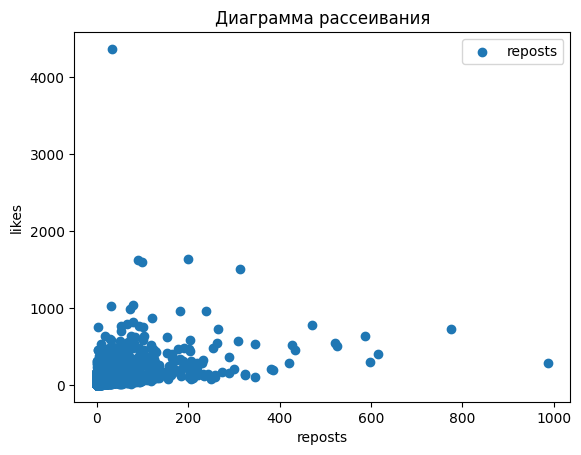

In [ ]:
# зависимость репостов от лайков
x = data_posts['reposts']
y = data_posts['likes']

fig, ax = plt.subplots()
plt.scatter(x, y, label = 'reposts')

plt.legend()
plt.ylabel('likes')
plt.xlabel('reposts')
plt.title('Диаграмма рассеивания')
plt.show()

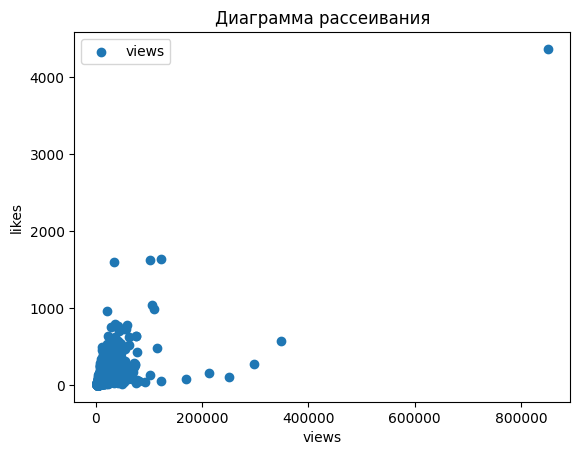

In [ ]:
# зависимость лайков от просмотров
x = data_posts['views']
y = data_posts['likes']

fig, ax = plt.subplots()
plt.scatter(x, y, label = 'views')

plt.legend()
plt.ylabel('likes')
plt.xlabel('views')
plt.title('Диаграмма рассеивания')
plt.show()

**Облако слов**

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


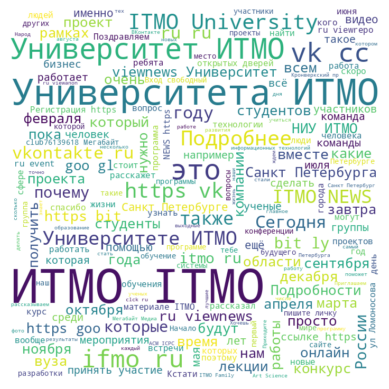

In [ ]:
# импорт библиотек
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# удаляем пустые строчки
text = data_posts['text'].astype(str).dropna()
# объединяем строчки из файла в одну
text = " ".join(text)

# токенизация текста
words = word_tokenize(text)

# загружаем стоп-слова на русском языке из nltk
stop_words = set(nltk.corpus.stopwords.words('russian'))
# удаляем стоп-слова из текста
filtered_words = [word for word in words if word.lower() not in stop_words]

# объединяем отфильтрованные слова обратно в строку
filtered_text = " ".join(filtered_words)

# собираем информацию в облако слов
wc = WordCloud(width=700, height=700, background_color="white")
wc.generate(filtered_text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

**Популярные биграммы**

In [ ]:
!pip install pymorphy3 > None
import nltk
from nltk.tokenize import word_tokenize
import pymorphy3
from string import punctuation
nltk.download('punkt')

In [ ]:
# функция предобработки текстов
morph = pymorphy3.MorphAnalyzer()
punktuations = list(punctuation)
punktuations.append('—')

def preproc (text):
  token = word_tokenize(text.lower())
  words_without_punkt = [i for i in token if (i not in punktuations)]
  lem = [morph.parse(i)[0].normal_form for i in words_without_punkt]
  return lem

In [ ]:
# удаляем пустые строчки
text = data_posts['text'].astype(str).dropna()
# объединяем строчки из файла в одну
text = " ".join(text)

# токенизация текста
words = word_tokenize(text)

# загружаем стоп-слова на русском языке из nltk
stop_words = set(nltk.corpus.stopwords.words('russian'))
# кастомные стоп-слова
custom_stop_words = {'это', 'вместе', 'а', 'где', 'https', 'с', 'в', 'по', 'далее', 'так', 'быть', '«', '70', 'nan', '--'}
# удаляем стоп-слова из текста
filtered_words = [word for word in words if word.lower() not in stop_words and word.lower() not in custom_stop_words]

# объединяем отфильтрованные слова обратно в строку
filtered_text = " ".join(filtered_words)

pd.Series(nltk.ngrams(preproc(filtered_text), 2))

,0
0,"(существовать, гайда)"
1,"(гайда, поступление)"
2,"(поступление, родителей…)"
3,"(родителей…, итмый)"
4,"(итмый, сбер)"
...,...
456170,"(...., человек)"
456171,"(человек, минимум)"
456172,"(минимум, думать)"
456173,"(думать, захотеть)"


In [ ]:
# считаем количество биграмм
pd.Series(nltk.ngrams(preproc(filtered_text), 2)).value_counts()

,count
"(университет, итмый)",5716
"(итмый, itmo)",3214
"(itmo, university)",919
"(подробный, http)",847
"(принять, участие)",365
...,...
"(первокурсник, выпускница)",1
"(итмый, assistant)",1
"(сан-диего, надежда)",1
"(поликарпов, приехать)",1


Text(0.5, 1.0, 'TOP 10 bigram')

<Figure size 2000x1000 with 0 Axes>

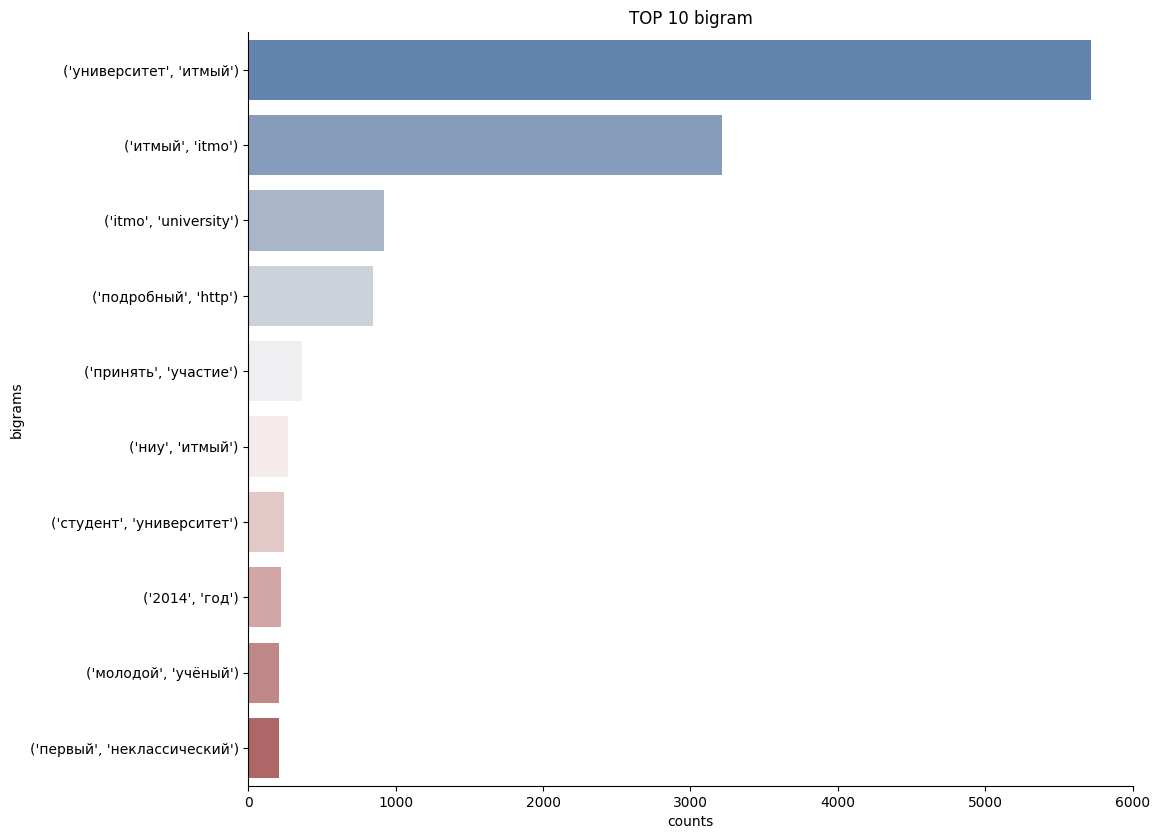

In [ ]:
# визуализация биграмм
import seaborn as sns
bigrams_series = (pd.Series(nltk.ngrams(preproc(filtered_text), 2)).value_counts())[:10]
bigrams_top = pd.DataFrame(bigrams_series.sort_values(ascending=False))
bigrams_top = bigrams_top.reset_index().rename(columns={'index': 'bigrams', 'count':'counts'})
bigrams_top['bigrams'] = bigrams_top['bigrams'].astype(str)
plt.figure(figsize=(20,10))
sns.catplot(x = 'counts' , y='bigrams', kind="bar", palette="vlag", data=bigrams_top, height=8.27, aspect=11.7/8.27)
plt.title('TOP 10 bigram')

Добавим столбец популярности текста для дальнейшей работы. Пусть пост считается популярным, если набрал более 30 лайков

In [ ]:
import csv

# открываем исходный CSV-файл для чтения
with open('ITMO_0.csv', 'r') as file:
    reader = csv.DictReader(file)
    rows = list(reader)

# получаем названия столбцов
fieldnames = reader.fieldnames + ['popular']

# открываем новый CSV-файл для записи
with open('ITMO_1.csv', 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    # проходимся по каждой строке и добавляем новый столбец
    for row in rows:
        likes = int(row['likes'])
        if likes > 30:
            row['popular'] = '1'
        else:
            row['popular'] = '0'
        writer.writerow(row)

In [ ]:
df = pd.read_csv('ITMO_1.csv')
df

,id_group,id_post,data,description,title,text,views,likes,reposts,popular
0,-94,57387,1716805478,NaN,NaN,"А что если бы существовал гайд по поступлению,...",14293.0,84,53,1
1,-94,57891,1725354045,Восходящая звезда телевидения — Антонина Итмош...,Клип @itmoru,NaN,10224.0,49,25,1
2,-94,57890,1725351793,Ловите ту самую атмосферу в видео 😉\n\nА инсай...,ITMO CONF 2024,"Грандиозно, экспертно, футуристично! \n \nВот ...",4993.0,37,10,1
3,-94,57877,1725105600,🏎 Гоооооооооооо \n\n...на ITMO GO!\n\nВ начале...,Промо ITMO GO! x ITMOTION | 07.09,🏎 Гоооооооооооо \n \n...на ITMO GO! \n \nВ нач...,8571.0,92,40,1
4,-94,57876,1725094801,NaN,NaN,[https://vk.com/public105042669|Сборная ИТМО #...,12343.0,95,7,1
...,...,...,...,...,...,...,...,...,...,...
15622,-94,5,1165260027,NaN,NaN,Всем привет!,NaN,0,0,0
15623,-94,4,1165259762,NaN,NaN,и почему тут никто не пишет?,NaN,1,0,0
15624,-94,3,1165258871,NaN,NaN,"ну вот, нас уже трое =)",NaN,0,0,0
15625,-94,2,1165257425,NaN,NaN,давай пытаться =),NaN,2,0,0


В рамках работы с датасетом было выполнено несколько преобразований. Каждый из них сохранен под определенным порядковым номером:
<li> ITMO_0.csv - исходный датасет в результате парсинга стены vk
<li> ITMO_1.csv - датасет с добавлением столбца популярности поста (если набрал > 30 лайков)
<li> ITMO_2.csv - датасет с токенизацией, лемматизацией и стеммингом
<li> ITMO_2_vectorized_bag_of_words.npz - векторизация через Bag of Words
<li> ITMO_2_vectorized_tf_idf.npz - векторизация через TF-IDF
<li> ITMO_2_vectorized_word2vec.npz.csv - векторизация через Word2Vec
<li> ITMO_3.csv - датасет с добавлением столбца по анализу сентимента (позитив, негатив, нейтралитет)

**Промежуточные выводы:**
<li> С использованием API VK был выполнен парсин данных из официальной группы ИТМО
<li> Собрана информация по 15627 постам (в датасете 15627 строк и 9 столбцов)
<li> Пост считается популярным, если набрал более 30-ти лайков